### <b>ConvNeXt</b>


In [4]:
import torch
import datetime
import torchvision
from torch import nn
from typing import List
from torch import Tensor
import torch.nn.functional as F

In [5]:
# In the papers the authors started by a simple ResNet-50
# Firstly we will create a class for creating a simple Conv + Normalization + Activation

class ConvNormActBlock(nn.Sequential):
    def __init__(self, in_channel: int, out_channel: int, kernel_size: int, norm = nn.BatchNorm2d, activation = nn.ReLU, **kwargs):
        """
        in_channel : The input feature size of the convolution
        out_channel : THe ouput feature size of the convolution
        kenel_size : size of the kernel (3 = (3, 3))
        norm : The normalization function, we use Batch Normalization for ResNet
        activation : The activation function, usually ReLU for ResNet
        """
        super().__init__(
            nn.Conv2d(in_channel, out_channel, kernel_size, padding= kernel_size//2, **kwargs),
            norm(out_channel),
            activation()
        )

In [6]:

# Now we'll define our ResNet block class

class ResNetBlock(nn.Module):
    """
    A class for returning the bottleneck
    bottleneck in ResNet is usually composed by:
    conv_block:
        - (1, 1) Conv + Normalization + Activation
        - (3, 3) Conv + Normalization + Activation
        - (1, 1) Conv + Normalization
    res_block : (1, 1) Conv + Normalization
        ResNet_block = conv_block + res_block
    """
    def __init__(self, in_features: int, out_features: int, cardinal: int = 4, stride: int = 1):
        super(ResNetBlock, self).__init__()
        reduced = out_features // cardinal

        self.conv_block = nn.Sequential(
            ConvNormActBlock(in_features, reduced, kernel_size=1, stride=stride),
            ConvNormActBlock(reduced, reduced, kernel_size=3),
            ConvNormActBlock(reduced, out_features, kernel_size=1, activation=nn.Identity)
        )
        if in_features != out_features:
            self.res_block = nn.Sequential(
                ConvNormActBlock(in_features, out_features, kernel_size=1, stride = stride)
            )
        else:
            self.res_block = nn.Identity()
        self.activation = nn.ReLU()
    
    def forward(self, x):
        residual = x
        x = self.conv_block(x)
        residual = self.res_block(residual)
        x += residual
        x = self.activation(x)
        return x

In [7]:
x = torch.rand(1, 32, 7, 7)
block = ResNetBlock(32, 64)
block(x).shape

torch.Size([1, 64, 7, 7])

In [11]:
class ConvNeXtStages(nn.Module):
    """
    Create ConvNext Stages
    """
    def __init__(self, ResNetBlock, states_list):
        super().__init__()
        self.in_features = 96
        self.stage2 = self._stages(ResNetBlock, states_list[0], output_channel = 96)
        self.stage3 = self._stages(ResNetBlock, states_list[1], output_channel = 192)
        self.stage4 = self._stages(ResNetBlock, states_list[2], output_channel = 384)
        self.stage5 = self._stages(ResNetBlock, states_list[3], output_channel = 768)
    
    def forward(self, x):
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        return x

    def _stages(self, ResNetBlock, residual_block, output_channel, stride: int = 2):
        stages_list = []

        # Here is the downsampling layer, It will downsample the input by a factor = 2
        stages_list.append(ResNetBlock(self.in_features, output_channel,
                                        stride = stride)),* [stages_list.append(ResNetBlock(output_channel,
                                                                                            output_channel)) for i in range(residual_block - 1)]
        return nn.Sequential(*stages_list)




In [14]:
ConvNeXtStages(ResNetBlock, [3,4,6,3])

ConvNeXtStages(
  (stage2): Sequential(
    (0): ResNetBlock(
      (conv_block): Sequential(
        (0): ConvNormActBlock(
          (0): Conv2d(96, 24, kernel_size=(1, 1), stride=(2, 2))
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): ConvNormActBlock(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (2): ConvNormActBlock(
          (0): Conv2d(24, 96, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
      (res_block): Identity()
      (activation): ReLU()
    )
    (1): ResNetBlock(
      (conv_block): Sequential(
        (0): ConvNormActBlock(
          (0): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 

In [22]:
out = ConvNeXtStages(ResNetBlock, [3,4,6,3])

In [23]:
class ConvNeXtStem(nn.Sequential):
  """
  Initially in ResNet, the stem layer is composed by
  a (7, 7) Conv + stride = 2 following with a MaxPool layer
  """
  def __init__(self, in_features: int, out_features: int, FULLCONV):
    super().__init__(
        ConvNormActBlock(in_features, out_features, kernel_size = 7, stride = 2),
        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
    )

In [24]:
class ResNet_ConvNeXt(nn.Module):
  """
  The final ResNet-50 class before we make some
  adjustements from the macro and micro design
  """
  def __init__(self, in_channel, stem_feature, depth_list, ConvNeXt_stages, ResNet_block, FULLCONV, ConvNeXt_stem):
    """
    in_channel : The input channel size
    stem_feature: The output of the stem layer
    depth_list : The list of our stages
    """
    super(ResNet_ConvNeXt, self).__init__()
    self.stem = ConvNeXt_stem(in_channel, stem_feature, FULLCONV)
    self.stages_list = nn.ModuleList([ConvNeXt_stages(ResNet_block, depth_list)])
  
  def forward(self, x):
    x = self.stem(x)
    print(x.shape)
    for stage in self.stages_list:
      x = stage(x)
    return x

In [25]:
image = torch.rand(1, 3, 224, 224)
encoder = ResNet_ConvNeXt(3, 96, [3,3,9,3], ConvNeXtStages, ResNetBlock, ConvNormActBlock, ConvNeXtStem)
encoder

ResNet_ConvNeXt(
  (stem): ConvNeXtStem(
    (0): ConvNormActBlock(
      (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stages_list): ModuleList(
    (0): ConvNeXtStages(
      (stage2): Sequential(
        (0): ResNetBlock(
          (conv_block): Sequential(
            (0): ConvNormActBlock(
              (0): Conv2d(96, 24, kernel_size=(1, 1), stride=(2, 2))
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (1): ConvNormActBlock(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
       

In [26]:
class ConvNeXtStem(nn.Sequential):
  """
  Initially in ResNet, the stem layer is composed by
  a (7, 7) Conv + stride = 2 following with a MaxPool layer
  We replace this with a single (4, 4) Conv + stride = 4 layer
  """
  def __init__(self, in_features: int, out_features: int, FULLCONV, **kwargs):
    super().__init__(
        nn.Conv2d(in_features, out_features, kernel_size = 4, stride = 4, **kwargs),
        nn.BatchNorm2d(out_features),
    )

In [27]:
encoder = ResNet_ConvNeXt(3, 64, [3,3,9,3], ConvNeXtStages, ResNetBlock, ConvNormActBlock, ConvNeXtStem)
encoder

ResNet_ConvNeXt(
  (stem): ConvNeXtStem(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stages_list): ModuleList(
    (0): ConvNeXtStages(
      (stage2): Sequential(
        (0): ResNetBlock(
          (conv_block): Sequential(
            (0): ConvNormActBlock(
              (0): Conv2d(96, 24, kernel_size=(1, 1), stride=(2, 2))
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (1): ConvNormActBlock(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (2): ConvNormActBlock(
              (0): Conv2d(24, 96, kernel_size=(1, 1), stride=(1, 1))
              (1): BatchNorm2d(96, eps=1e-05, momentum=0.1

In [28]:
class ConvNeXtStem(nn.Sequential):
  """
  Initially in ResNet, the stem layer is composed by
  a (7, 7) Conv + stride = 2 following with a MaxPool layer
  We replace this with a single (4, 4) Conv + stride = 4 layer
  """
  def __init__(self, in_features: int, out_features: int, FULLCONV, **kwargs):
    super().__init__(
        nn.Conv2d(in_features, out_features, kernel_size = 4, stride = 4, **kwargs),
        nn.BatchNorm2d(out_features),
    )

In [29]:
encoder = ResNet_ConvNeXt(3, 64, [3,3,9,3],ConvNeXtStages, ResNetBlock, ConvNormActBlock, ConvNeXtStem)
encoder

ResNet_ConvNeXt(
  (stem): ConvNeXtStem(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stages_list): ModuleList(
    (0): ConvNeXtStages(
      (stage2): Sequential(
        (0): ResNetBlock(
          (conv_block): Sequential(
            (0): ConvNormActBlock(
              (0): Conv2d(96, 24, kernel_size=(1, 1), stride=(2, 2))
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (1): ConvNormActBlock(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (2): ConvNormActBlock(
              (0): Conv2d(24, 96, kernel_size=(1, 1), stride=(1, 1))
              (1): BatchNorm2d(96, eps=1e-05, momentum=0.1

In [30]:
encoder

ResNet_ConvNeXt(
  (stem): ConvNeXtStem(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stages_list): ModuleList(
    (0): ConvNeXtStages(
      (stage2): Sequential(
        (0): ResNetBlock(
          (conv_block): Sequential(
            (0): ConvNormActBlock(
              (0): Conv2d(96, 24, kernel_size=(1, 1), stride=(2, 2))
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (1): ConvNormActBlock(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
            (2): ConvNormActBlock(
              (0): Conv2d(24, 96, kernel_size=(1, 1), stride=(1, 1))
              (1): BatchNorm2d(96, eps=1e-05, momentum=0.1

In [39]:
class ResNetBlock(nn.Module):
  """
  A class for returning the bottleneck
  bottleneck in ResNet is usually composed by:
  main_path:
    - (7, 7) Conv + Normalization + Activation
    - (1, 1) Conv + Normalization + Activation
    - (1, 1) Conv + Normalization
  short_path : (1, 1) Conv + Normalization
    ResNet_block = main_path + shortcut
  """
  def __init__(self, in_features: int, out_features: int, cardinality: int = 4, stride: int = 1,):
    """
    in_features = The input feature size
    out_features = The output features size
    cardinality = Use to control the reduction and expansion of input and output size through a stage
    stride = Essentially used to shrink the kernel size
    """
    super(ResNetBlock, self).__init__()
    expansion = out_features*cardinality

    self.main_path = nn.Sequential(
        nn.Conv2d(in_features, in_features, kernel_size=7, stride=stride, groups = in_features),
        # Layer Normalization
        nn.GroupNorm(num_groups=1, num_channels=in_features),

        nn.Conv2d(in_features, expansion, kernel_size=1),
        #Apply the GELU
        nn.GELU(),

        nn.Conv2d(expansion, out_features, kernel_size=1),
        # The Identity module returns the input without any manipulation applied
        # It will be useful for adding the short_path 
    )
    if in_features != out_features:
      self.short_path = nn.Sequential(
          ConvNormActBlock(in_features, out_features, kernel_size=1, stride = stride)
      )
    else:
      self.short_path = nn.Identity()
    
  def forward(self, x):
    residual = x
    x = self.main_path(x)
    residual = self.short_path(residual)
    x += residual
    return x

In [40]:
class ConvNeXtStages(nn.Module):
  """
  Create ConvNeXtStages
  """
  def __init__(self, ResNet_block, stages_list):
    super().__init__()
    self.in_features = 96
    self.stage2 = self._stages(ResNet_block, stages_list[0], output_channel = 96)
    self.stage3 = self._stages(ResNet_block, stages_list[1], output_channel = 192)
    self.stage4 = self._stages(ResNet_block, stages_list[2], output_channel = 384)
    self.stage5 = self._stages(ResNet_block, stages_list[3], output_channel = 768)
  
  def forward(self, x):
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = self.stage5(x)
    return x


  def _stages(self, ResNetBlock, residual_blocks, output_channel, stride : int = 2):
    stages_list = []
    #output = self.in_features

    # Here is the downsampling layer, It will downsample the input by a factor = 2
    stages_list.append(nn.Sequential(
        nn.GroupNorm(num_groups=1, num_channels=self.in_features),
        nn.Conv2d(self.in_features, output_channel, kernel_size=2 , stride=2),
    )),*[stages_list.append(ResNetBlock(output_channel, output_channel)) for i in range(residual_blocks - 1)]
     
    
    return nn.Sequential(*stages_list)

In [41]:
ConvNeXtStages(ResNetBlock, [3,3,9,3])

ConvNeXtStages(
  (stage2): Sequential(
    (0): Sequential(
      (0): GroupNorm(1, 96, eps=1e-05, affine=True)
      (1): Conv2d(96, 96, kernel_size=(2, 2), stride=(2, 2))
    )
    (1): ResNetBlock(
      (main_path): Sequential(
        (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), groups=96)
        (1): GroupNorm(1, 96, eps=1e-05, affine=True)
        (2): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
        (3): GELU(approximate='none')
        (4): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (short_path): Identity()
    )
    (2): ResNetBlock(
      (main_path): Sequential(
        (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), groups=96)
        (1): GroupNorm(1, 96, eps=1e-05, affine=True)
        (2): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
        (3): GELU(approximate='none')
        (4): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (short_path): Identity()
    )
  )
  (stage3): Sequential(
    (0):

In [42]:
from torchvision.ops import StochasticDepth

class LayerScaler(nn.Module):
    def __init__(self, init_value: float, dimensions: int):
        super().__init__()
        self.gamma = nn.Parameter(init_value * torch.ones((dimensions)), 
                                    requires_grad=True)
        
    def forward(self, x):
        return self.gamma[None,...,None,None] * x

In [47]:
class ResNetBlock(nn.Module):
  """
  A class for returning the bottleneck
  bottleneck in ResNet is usually composed by:
  main_path:
    - (7, 7) Conv + Normalization + Activation
    - (1, 1) Conv + Normalization + Activation
    - (1, 1) Conv + Normalization
  short_path : (1, 1) Conv + Normalization
    ResNet_block = main_path + shortcut
  """
  def __init__(self, in_features: int, out_features: int, cardinality: int = 4, stride: int = 1,
              drop_p: float = .0,
              layer_scaler_init_value: float = 1e-6,):
    """
    in_features = The input feature size
    out_features = The output features size
    cardinality = Use to control the reduction and expansion of input and output size through a stage
    stride = Essentially used to shrink the kernel size
    """
    super(ResNetBlock, self).__init__()
    expansion = out_features*cardinality

    self.main_path = nn.Sequential(
        nn.Conv2d(in_features, in_features, kernel_size=7, stride=stride, padding = 3, groups = in_features),
        # Layer Normalization
        
        nn.LayerNorm([3, 224, 244]),

        nn.Conv2d(in_features, expansion, kernel_size=1),
        #Apply the GELU
        nn.GELU(),

        nn.Conv2d(expansion, out_features, kernel_size=1), 
    )
    self.layer_scaler = LayerScaler(layer_scaler_init_value, out_features)
    self.drop_path = StochasticDepth(drop_p, mode="batch")


  def forward(self, x):
    residual = x
    x = self.main_path(x)
    x = self.layer_scaler(x)
    x = self.drop_path(x)
    x += residual
    return x

In [56]:
class ClassificationHead(nn.Sequential):
    def __init__(self, num_channels: int, num_classes: int = 10):
        super().__init__(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(1),
            nn.LayerNorm(num_channels),
            nn.Linear(num_channels, num_classes)
        )
    
    
class ConvNextForImageClassification(nn.Sequential):
    def __init__(self, in_channels: int, stem_features: int, depth_list, ConvNeXt_stages, ResNet_block, FULLCONV, ConvNeXt_stem,
                 num_classes: int = 10):
        super().__init__()
        self.encoder = ResNet_ConvNeXt(3, 96, [3,3,9,3], ConvNeXt_stages, ResNet_block, FULLCONV, ConvNeXt_stem)
        self.head = ClassificationHead(768, num_classes)

In [57]:
model = ConvNextForImageClassification(3, 96, [3,3,9,3], ConvNeXtStages, ResNetBlock, ConvNormActBlock, ConvNeXtStem)
model

ConvNextForImageClassification(
  (encoder): ResNet_ConvNeXt(
    (stem): ConvNeXtStem(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (stages_list): ModuleList(
      (0): ConvNeXtStages(
        (stage2): Sequential(
          (0): Sequential(
            (0): GroupNorm(1, 96, eps=1e-05, affine=True)
            (1): Conv2d(96, 96, kernel_size=(2, 2), stride=(2, 2))
          )
          (1): ResNetBlock(
            (main_path): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (1): LayerNorm((3, 224, 244), eps=1e-05, elementwise_affine=True)
              (2): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
              (3): GELU(approximate='none')
              (4): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
            )
            (layer_scaler): LayerScaler()
            (drop_path

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100: Training loss = 1.8527534482119334
Epoch 2/100: Training loss = 1.756840763037162
Epoch 3/100: Training loss = 1.6742763816548125
Epoch 4/100: Training loss = 1.577095134331442
Epoch 5/100: Training loss = 1.5276817613855347
Epoch 6/100: Training loss = 1.4902408188566223
Epoch 7/100: Training loss = 1.4670610269317237
Epoch 8/100: Training loss = 1.4512811714730909
Epoch 9/100: Training loss = 1.4433343976050081
Epoch 10/100: Training loss = 1.4279533635319956
Epoch 11/100: Training loss = 1.4277201220202629
Epoch 12/100: Training loss = 1.4107219953366252
Epoch 13/100: Training loss = 1.408623217469286
Epoch 14/100: Training loss = 1.40343304851171
Epoch 15/100: Training loss = 1.3964257029926075
Epoch 16/100: Training loss = 1.3874163905068126
Epoch 17/100: Training loss = 1.3751329287238743
Epoch 18/100: Training loss = 1.3608733677803098
Epoch 19/100: Training loss = 1.3545409370108943
Epoch 2

Text(0, 0.5, 'Training loss')

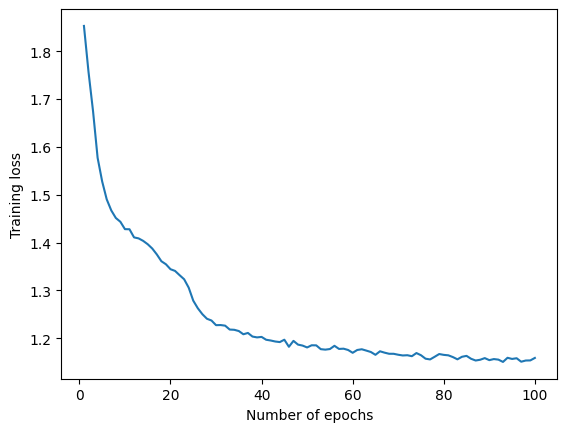

In [68]:
import torch
import torch.nn as nn
import torchvision.datasets
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.transforms import (CenterCrop, Compose,
                                    ToTensor, RandAugment, Normalize)
from timm.data.mixup import Mixup
from timm.data.random_erasing import RandomErasing

#Initializing normalizing transform for the dataset
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5), 
                                     std = (0.5, 0.5, 0.5))])

# transforms_train = Compose([
#         CenterCrop(64),
#         Normalize(mean = (0.5, 0.5, 0.5), 
#                  std = (0.5, 0.5, 0.5)),
#         RandAugment(num_ops=2, magnitude=9),
#         ToTensor()
#     ])

# mixup_args = {
#         'mixup_alpha': 0.8,
#         'cutmix_alpha': 1.0,
#         'cutmix_minmax': None,
#         'prob': 0.4,
#         'switch_prob': 0.5,
#         'mode': 'elem',
#         'label_smoothing': 0.1,
#         'num_classes': 10
#     }

# mixup = Mixup(**mixup_args)
# rand_erasing = RandomErasing(probability=0.25, max_area=1/4, mode="pixel")

#Downloading the CIFAR10 dataset into train and test sets
train_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/train", train=True,
    transform=normalize_transform,
    download=True)
    
test_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/test", train=False,
    transform=normalize_transform,
    download=True)
    
#Generating data loaders from the corresponding datasets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Selecting the appropriate training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize ConvNeXt
model.to(device)
  
#Defining the model hyper parameters
num_epochs = 100
learning_rate = 1e-3
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=1,
    eta_min=1e-5,
    last_epoch=-1
)

#Training process begins
train_acc = 0
train_loss_list = []
train_acc_list = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    train_loss = 0
      
    #Iterating over the training dataset in batches
    model.train()
    for i, (images, labels) in enumerate(train_loader):
          
        #Extracting images and target labels for the batch being iterated
        images = images.to(device)
        labels = labels.to(device)
  
        # images, labels = mixup(images, labels)
        # images = rand_erasing(images)
        #Calculating the model output and the cross entropy loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        # _, y_pred = torch.max(outputs.data, 1)
        # train_acc = (y_pred == labels).sum().item()
        #Updating weights according to calculated loss
        optimizer.zero_grad()
        loss.backward()
        lr_scheduler.step()
        optimizer.step()
        train_loss += loss.item()
      
    #Printing loss for each epoch
    train_loss_list.append(train_loss/len(train_loader))
    train_acc_list.append(train_acc/len(train_loader))
    print(f"Training loss = {train_loss_list[-1]}")   
      
#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")

In [69]:
test_acc=0
model.eval()
  
with torch.no_grad():
    #Iterating over the training dataset in batches
    for i, (images, labels) in enumerate(test_loader):
          
        images = images.to(device)
        y_true = labels.to(device)
          
        #Calculating outputs for the batch being iterated
        outputs = model(images)
          
        #Calculated prediction labels from models
        _, y_pred = torch.max(outputs.data, 1)
          
        #Comparing predicted and true labels
        test_acc += (y_pred == y_true).sum().item()
      
    print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")

Test set accuracy = 58.22 %
